# Predicting Transits During K2

In [1]:
push!(LOAD_PATH, "../code")

3-element Array{Any,1}:
 "/Users/farr/Documents/code/julia/usr/local/share/julia/site/v0.6"
 "/Users/farr/Documents/code/julia/usr/share/julia/site/v0.6"      
 "../code"                                                         

In [23]:
using Aldebaran
using CARMAKepler
using Ensemble
using HDF5
using Kepler
using PyCall
using PyPlot

@pyimport seaborn as sns
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

In [4]:
ts, ys, dys = Aldebaran.load_timeseries();

In [5]:
tmed = median(vcat(ts...))
ts = [t-tmed for t in ts];

In [6]:
tmin = minimum([minimum(t) for t in ts])
tmax = maximum([maximum(t) for t in ts])
T = tmax - tmin
muHz = 1e-6*(3600.0*24.0);

In [8]:
post1 = CARMAKepler.MultiEpochPosterior(ts, ys, dys, 600.0, 700.0, 1, 1, 1.0/(2*T), 0.05*muHz, 0.1*muHz, 10*muHz, 1000.0);

In [13]:
ps, ns = h5open("carma-1-kepler.h5", "r") do f
    mus = read(f, "mu")'
    nus = read(f, "nu")'
    Ks = read(f, "K")
    Ps = read(f, "P")
    es = read(f, "e")
    omegas = read(f, "omega")
    chis = read(f, "chi")
    
    drw_rmss = read(f, "drw_rms")'
    drw_rates = read(f, "drw_rate")'
    
    osc_rmss = read(f, "osc_rms")'
    osc_freqs = read(f, "osc_freq")'
    osc_Qs = read(f, "osc_Q")'
    
    [CARMAKepler.MultiEpochParams(mus[:,i], nus[:,i], Ks[i], Ps[i], es[i], omegas[i], chis[i], drw_rmss[:,i], drw_rates[:,i], osc_rmss[:,i], osc_freqs[:,i], osc_Qs[:,i]) for i in 1:size(mus, 2)], EnsembleNest.NestState(f["nest_state"], logl=(x->CARMAKepler.log_likelihood(post1, x)), logp=(x->CARMAKepler.log_prior(post1,x)))
end;

The RV signal is 
$$
v_r = K \left[ \cos \left( f\left( t - \chi P \right) + \omega \right) + e \cos \omega \right],
$$
where $f(t)$ is the true anomaly (measured from pericentre) for the orbit at time $t$.  (Thus, pericentre passage occurs at $t = \left( \chi + N \right) P$ for $N = \ldots, -1, 0, 1, \ldots$.)  The geometry is a bit hard to work out, but considering an orbit with $e = \omega = 0$, we see that the radial velocity is maximised when $f = 0$.  This means that the observer is located at infinity on the $+\hat{y}$ axis if pericentre is measured from the $+\hat{x}$ axis.  In this geometry, transit can occur (assuming $i = 0$ or $i = \pi$) whenever $f + \omega = \pi/2$.

In [14]:
function bisect_zero(f, a, b)
    bisect_zero(f, a, b, f(a), f(b))
end

function bisect_zero(f, a, b, fa, fb)
    if abs(b-a) < 1e-8
        (b*fa - a*fb)/(fa-fb)
    else
        m = 0.5*(a + b)
        fm = f(m)
        
        if fa*fm < 0
            bisect_zero(f, a, m, fa, fm)
        else
            bisect_zero(f, m, b, fm, fb)
        end
    end
end

bisect_zero (generic function with 2 methods)

A quick test:

In [17]:
abs(bisect_zero(x -> x*x-2.0, 1.0, 2.0) - sqrt(2))

0.0

The logic below is: find the true anomaly, $f$, that satisfies $f + \omega = \pi/2 + 2 N \pi$ and $0 \leq f < 2\pi$.  Then solve for the mean anomaly that corresponds to that $f$, find the first transit time, $\tau$, such that $\tau \geq 0$ and $\tau < P$, and then find the smallest $M$ such that $\tau + M P > t_0$.  Whew.

In [40]:
function next_transit_time(p, t0)
    """
    Returns the next time the planet will transit after ``t0`` for parameters ``p``.
    """
    P = p.P
    e = p.e
    omega = p.omega
    chi = p.chi
    
    if omega < 0.0
        omega += 2.0*pi
    end
    
    ftr = pi/2.0 - omega
    if ftr < 0.0
        ftr += 2.0*pi
    end
    
    Mtr = bisect_zero(m -> Kepler.true_anom(Kepler.ecc_anom(m, e), e)-ftr, 1e-12, 2*pi-1e-12)
    ttr = P*(Mtr/(2.0*pi) + chi)
    
    if ttr > P
        ttr -= P
    end
    
    fp, ip = modf(t0/P)
    ttry = ip*P + ttr
    if ttry < t0
        ttry + P
    else
        ttry
    end
end

next_transit_time (generic function with 1 method)

Using the [USNO Julian Date Converter](http://aa.usno.navy.mil/jdconverter?ID=AA&year=2017&month=3&day=8&era=1&hr=0&min=0&sec=0.0), I find that 2017 Mar 08 (the start of [K2 Campaign 13](https://keplerscience.arc.nasa.gov/k2-fields.html)) is JD2457820.5 and the end of K2 C13, 2017 May 27, is JD2457901.5$-\epsilon$.  The origin of time for our simulations in the median time, so we translate these appropriately.

In [44]:
TC13JD = 2457820.5
TC130 = TC13JD - tmed

TC13JDEnd = 2457901.499999
TC130End = TC13JDEnd - tmed

2062.5468990001827

Here is the posterior over the transit time:

In [45]:
ttrs = [next_transit_time(p, TC130) for p in ps];

And a plot, plus a calculation for the fraction of samples that are between the start (guaranteed) and end of K2 C13.

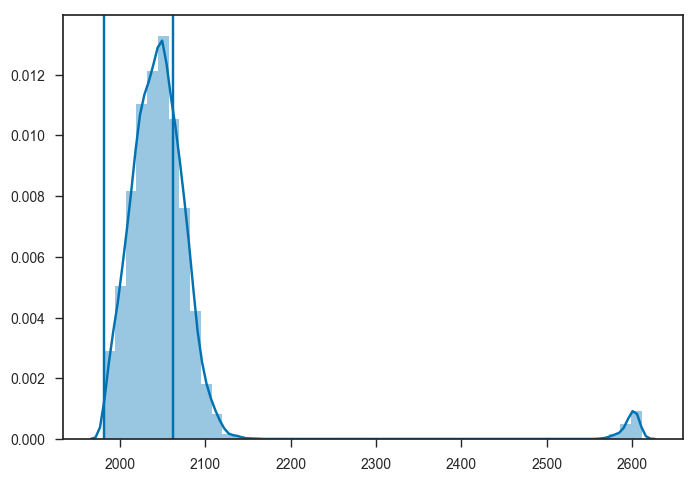

P(transit in K2 C13) = 0.72


In [48]:
sns.distplot(ttrs)
axvline(TC130End)
axvline(TC130)
println(@sprintf("P(transit in K2 C13) = %.2f", sum(ttrs .< TC130End)/size(ttrs,1)))

Let's plot the derivative of our RVs between the start and end of K2 C13; for small eccentricities, transit happens near the minimum of radial *acceleration* (the star is accelerated toward the planet and therefore the observer at transit, and since the separation between them doesn't vary much over the orbit the favorable angle for the acceleration dominates over the variation in magnitude through the orbit).

In [58]:
ts = linspace(TC130, TC130End, 1000)
ts_cent = 0.5*(ts[1:end-1] + ts[2:end])
rvs = []
for p in rand(ps, 1024)
    push!(rvs, [Kepler.rv(t, p.K, p.P, p.e, p.omega, p.chi) for t in ts])
end
rvs = hcat(rvs...)
drvs = diff(rvs, 1)/(ts[2]-ts[1]);

In [59]:
ll = Float64[]
l = Float64[]
m = Float64[]
h = Float64[]
hh = Float64[]
for i in 1:size(drvs,1)
    v = vec(drvs[i,:])
    push!(ll, quantile(v, 0.025))
    push!(l, quantile(v, 0.16))
    push!(m, median(v))
    push!(h, quantile(v, 0.84))
    push!(hh, quantile(v, 0.975))
end

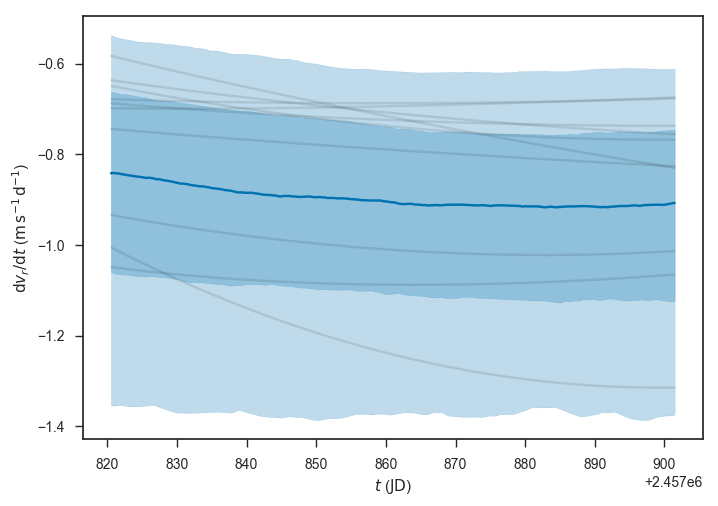

PyObject <matplotlib.text.Text object at 0x14088dc50>

In [60]:
plot(ts_cent+tmed, m)
fill_between(ts_cent+tmed, h, l, color=sns.color_palette()[1], alpha=0.25)
fill_between(ts_cent+tmed, hh, ll, color=sns.color_palette()[1], alpha=0.25)
for i in 1:10
    j = rand(1:size(drvs,2))
    plot(ts_cent+tmed, drvs[:,j], color="k", alpha=0.1)
end
xlabel(L"$t$ ($\mathrm{JD}$)")
ylabel(L"$\mathrm{d} v_r / \mathrm{d} t$ ($\mathrm{m} \, \mathrm{s}^{-1} \, \mathrm{d}^{-1}$)")

I guess we *aren't* very certain about what is happening here exactly with respect to the RVs.  The major problem is that we don't really know the orientation of the orbit very well, I guess:

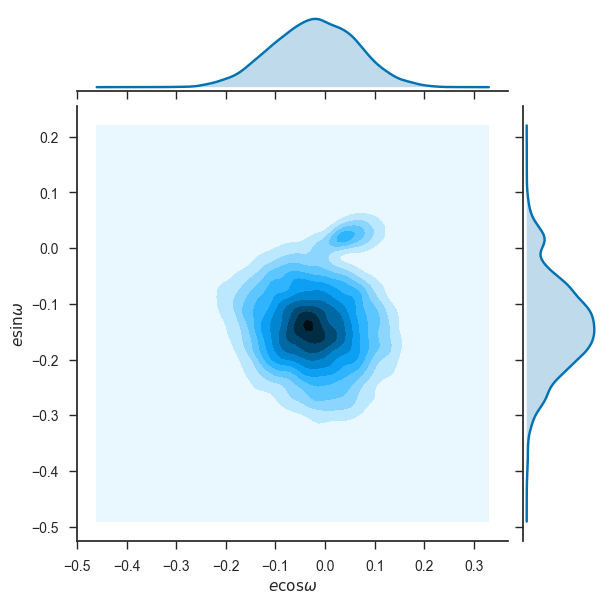

PyObject <seaborn.axisgrid.JointGrid object at 0x14059e550>

In [63]:
sns.jointplot([p.e*cos(p.omega) for p in ps], [p.e*sin(p.omega) for p in ps], stat_func=nothing, kind="kde")[:set_axis_labels](L"$e \cos \omega$", L"$e \sin \omega$")